In [1]:
import torch
import torch.nn as nn
import numpy as np
import gymnasium as gym
from collections import deque
import pygame
import random
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [9]:
def Policy_Gradient_Train_CartPole_model(model,loss_fn,optimizer,return_calc,episodes=1500,gamma=0.99):
  global total_rewards
  env = gym.make("CartPole-v1")
  model.train()
  total_rewards=[]
  for episode in range(episodes):

    obs,_=env.reset()
    max_length=500
    length=0
    done=False
    log_probabilities=[]
    rewards=[]
    total_reward=0

    while not done:

      state=torch.from_numpy(obs).float().to(device)
      policy=model(state)
      policy=torch.squeeze(policy)
      probs = torch.nn.functional.softmax(policy, dim=0)
      action = torch.multinomial(probs, num_samples=1).item()
      log_probabilities.append(torch.log(probs[action]))
      obs, reward, done, _ , _ = env.step(action)
      total_reward+=reward
      rewards.append(reward)

      length+=1
      if length==max_length:
        done=True

    returns=return_calc(rewards,gamma)
    loss=loss_fn(log_probabilities,returns)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_rewards.append(total_reward)
    if episode%50==0:
      print(f"Episode = {episode} Average Reward = {sum(total_rewards[-50::])/50}")
      if sum(total_rewards[-50::])/50>=470:
        break
  env.close()

In [5]:
def return_calc(rewards, gamma):
    ep_len = len(rewards)
    rewards = torch.tensor(rewards, dtype=torch.float32)
    discounted = rewards * torch.pow(gamma, torch.arange(ep_len, dtype=torch.float32))
    returns = torch.flip(torch.cumsum(torch.flip(discounted, dims=[0]), dim=0), dims=[0])
    returns = returns / torch.pow(gamma, torch.arange(ep_len, dtype=torch.float32))
    returns = (returns - returns.mean()) / (returns.std())
    return returns
def loss_fn(log_probabilities,returns):
  log_prob_tensor = torch.stack(log_probabilities)
  returns_tensor = torch.tensor(returns, dtype=torch.float32).detach().to(device)
  loss = -torch.sum(log_prob_tensor * returns_tensor)
  return loss

In [11]:
class PG_CartPole(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.sequential_net=nn.Sequential(
                            nn.Linear(4,128),
                            nn.LeakyReLU(),
                            nn.Linear(128,2),
                            )
    def forward(self, input):
        input=input.view(-1,4)
        return self.sequential_net(input)
model=PG_CartPole().to(device)
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)
Policy_Gradient_Train_CartPole_model(model,loss_fn,optimizer,return_calc)

/tmp/ipython-input-10-3631928974.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  returns_tensor = torch.tensor(returns, dtype=torch.float32).detach().to(device)


Episode = 0 Average Reward = 0.26
Episode = 50 Average Reward = 20.44
Episode = 100 Average Reward = 18.4
Episode = 150 Average Reward = 33.62
Episode = 200 Average Reward = 46.22
Episode = 250 Average Reward = 70.8
Episode = 300 Average Reward = 106.38
Episode = 350 Average Reward = 188.7
Episode = 400 Average Reward = 199.76
Episode = 450 Average Reward = 327.7
Episode = 500 Average Reward = 388.42
Episode = 550 Average Reward = 440.82
Episode = 600 Average Reward = 401.68
Episode = 650 Average Reward = 329.36
Episode = 700 Average Reward = 430.48
Episode = 750 Average Reward = 486.98


[]

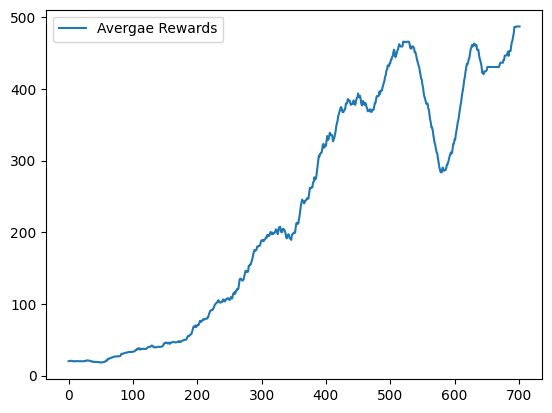

In [12]:
plt.plot(np.convolve(total_rewards,np.ones(50)*0.02,mode='valid'),label='Avergae Rewards')
plt.legend()
plt.plot()

In [13]:
def evaluate_cartpole_model(model, episodes=15, render=True):
    env = gym.make("CartPole-v1", render_mode="human" if render else None)
    obs_dim = env.observation_space.shape[0]
    n_actions = env.action_space.n

    model.eval()

    rewards = []

    for episode in range(episodes):
        obs, _ = env.reset()
        total_reward = 0
        done = False

        while not done:
            state = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).to(device)
            with torch.no_grad():
                q_values = model(state)
                action = torch.argmax(q_values, dim=1).item()
            obs, reward, done, truncated, _ = env.step(action)
            if truncated:
              done=True
            total_reward += reward
            if render:
                env.render()
        rewards.append(total_reward)
        print(f"Episode {episode + 1}: Reward = {total_reward}")

    env.close()
    avg_reward = sum(rewards) / episodes
    print(f"Average reward over {episodes} episodes: {avg_reward}")

In [14]:
evaluate_cartpole_model(model,render=False)


Episode 1: Reward = 500.0
Episode 2: Reward = 500.0
Episode 3: Reward = 500.0
Episode 4: Reward = 500.0
Episode 5: Reward = 500.0
Episode 6: Reward = 500.0
Episode 7: Reward = 500.0
Episode 8: Reward = 500.0
Episode 9: Reward = 500.0
Episode 10: Reward = 500.0
Episode 11: Reward = 500.0
Episode 12: Reward = 500.0
Episode 13: Reward = 500.0
Episode 14: Reward = 500.0
Episode 15: Reward = 500.0
Average reward over 15 episodes: 500.0
